In [87]:
import librosa
import soundfile
import scipy
import sklearn
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import kagglehub
import random
import shutil

# OPTIONS
Here you can set various options.

In [88]:
# Parameters
GTZAN_TRAIN_RATIO = 0.8

DATA_DIR = Path("data-split") # Specifies the directory that contains the dataset that will be used.

Ks = [2, 8, 16, 64]

WIN_MS = 20
STEP_MS = 5

# Run options
GTZAN_FETCH = False # Downloads and splits GTZAN Dataset to train and test samples
TRAIN = True # Specifies whether to train the GMM Models
BUILD_FEATURES = True

In [89]:
if GTZAN_FETCH:
    path = kagglehub.dataset_download(
        "andradaolteanu/gtzan-dataset-music-genre-classification"
    )
    
    print("Downloaded to:", path)
    
    TARGET_ROOT = Path("data-gtzan")
    TARGET_ROOT.mkdir(exist_ok=True)
    
    dataset_path = Path(path)
    
    SOURCE_ROOT = dataset_path / "Data" / "genres_original"
    
    for genre_dir in SOURCE_ROOT.iterdir():
        if not genre_dir.is_dir():
            continue
    
        target_genre = TARGET_ROOT / genre_dir.name
        target_genre.mkdir(parents=True, exist_ok=True)
    
        for wav in genre_dir.glob("*.wav"):
            shutil.copy2(wav, target_genre / wav.name)

    DATASET_DIR = Path("data-gtzan")
    
    GENRES = sorted([p.name for p in DATASET_DIR.iterdir() if p.is_dir()])
    
    songs_by_genre = {
        genre: list((DATASET_DIR / genre).glob("*.wav"))
        for genre in GENRES
    }
    
    train_songs = {}
    test_songs = {}
    
    random.seed(42)
    
    for genre, songs in songs_by_genre.items():
        random.shuffle(songs)
        split = int(len(songs) * GTZAN_TRAIN_RATIO)
        train_songs[genre] = songs[:split]
        test_songs[genre] = songs[split:]
    
    SPLIT_DIR = Path("data-split")
    
    for split in ["train", "test"]:
        for genre in GENRES:
            (SPLIT_DIR / split / genre).mkdir(parents=True, exist_ok=True)
    
    for genre in GENRES:
        for f in train_songs[genre]:
            shutil.copy2(f, SPLIT_DIR / "train" / genre / f.name)
    
        for f in test_songs[genre]:
            shutil.copy2(f, SPLIT_DIR / "test" / genre / f.name)

In [90]:
FEAT_DIR = Path("features")
MODEL_DIR = Path("models")

TARGET_SR = 22050
N_MFCC = 13

FEAT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

def extract_mfcc(path: Path) -> np.ndarray:
    try:
        y, sr = librosa.load(
            str(path),          # 🔴 CRITICAL FIX
            sr=TARGET_SR,
            mono=True,
            duration=30.0       # prevents hanging
        )
    except Exception as e:
        print(f"❌ Skipping {path.name}: {e}")
        return np.empty((0, N_MFCC), dtype=np.float32)

    if y.size == 0:
        return np.empty((0, N_MFCC), dtype=np.float32)

    win_length = int((WIN_MS / 1000) * sr)
    hop_length = int((STEP_MS / 1000) * sr)

    n_fft = 1
    while n_fft < win_length:
        n_fft *= 2

    mfcc = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=N_MFCC,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
    ).T

    return mfcc.astype(np.float32)

def build_features():
    for split in ["train", "test"]:
        for genre in GENRES:
            in_dir = DATA_DIR / split / genre
            out_dir = FEAT_DIR / split / genre
            out_dir.mkdir(parents=True, exist_ok=True)

            files = list_audio_files(in_dir)
            if not files:
                print(f"⚠️ No audio files in {in_dir}")
                continue

            for f in tqdm(files, desc=f"MFCC {split}/{genre}", unit="file"):
                mfcc = extract_mfcc(f)

                np.savez_compressed(
                    out_dir / f"{f.stem}.npz",
                    mfcc=mfcc,
                    label=genre,
                    source=str(f)
                )

def load_genre_train_frames(genre: str) -> np.ndarray:
    """
    Loads and concatenates all MFCC frames for a given genre
    from features/train/{genre}/*.npz
    Returns: array of shape (total_frames, n_mfcc)
    """
    files = sorted((Path("features/train") / genre).glob("*.npz"))
    if not files:
        raise RuntimeError(f"No training features found for genre '{genre}'")

    frames = []
    for f in files:
        data = np.load(f)
        frames.append(data["mfcc"])

    return np.vstack(frames)

def train_gmm_system(K: int):
    # Load all training frames (for scaling)
    all_frames = np.vstack([load_genre_train_frames(g) for g in GENRES])

    scaler = StandardScaler().fit(all_frames)
    joblib.dump(scaler, MODEL_DIR / "scaler.joblib")

    models = {}

    # 🔵 Progress bar here
    for genre in tqdm(GENRES, desc=f"Training GMMs (K={K})"):
        X = load_genre_train_frames(genre)
        X = scaler.transform(X)

        gmm = GaussianMixture(
            n_components=K,
            covariance_type="diag",
            max_iter=200,
            reg_covar=1e-6,
            random_state=0
        )

        gmm.fit(X)

        models[genre] = gmm
        joblib.dump(gmm, MODEL_DIR / f"gmm_{genre}_K{K}.joblib")

    return models

In [91]:
def load_models(K):
    scaler = joblib.load(MODEL_DIR / "scaler.joblib")
    gmms = {g: joblib.load(MODEL_DIR / f"gmm_{g}_K{K}.joblib") for g in GENRES}
    return scaler, gmms

def classify_track(feature_file, scaler, gmms):
    data = np.load(feature_file)
    X = scaler.transform(data["mfcc"])

    # Average log-likelihood per frame
    scores = {g: gmms[g].score(X) for g in GENRES}

    predicted = max(scores, key=scores.get)
    return predicted, scores

def evaluate_system(K):
    scaler, gmms = load_models(K)

    y_true, y_pred = [], []

    for true_genre in GENRES:
        test_files = (FEAT_DIR / "test" / true_genre).glob("*.npz")

        for f in tqdm(test_files, desc=f"Evaluating K={K}, true={true_genre}"):
            pred, _ = classify_track(f, scaler, gmms)
            y_true.append(true_genre)
            y_pred.append(pred)

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=GENRES)
    return acc, cm

def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(6, 5))

    im = ax.imshow(cm)

    # Axis ticks & labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels(labels, fontsize=12)

    ax.set_xlabel("Predicted label", fontsize=13)
    ax.set_ylabel("True label", fontsize=13)
    ax.set_title(title, fontsize=14, pad=10)

    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # BIG + BOLD numbers inside cells
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(
                j, i, cm[i, j],
                ha="center",
                va="center",
                fontsize=18,          # 👈 BIG
                fontweight="bold",    # 👈 BOLD
                color="white" if cm[i, j] > cm.max() / 2 else "black"
            )

    # Colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=11)

    fig.tight_layout()
    plt.show()


MFCC train/jazz:  55%|██████▌     | 44/80 [00:03<00:03, 11.57file/s]/var/folders/6n/f8xp3w5n4tvb78ssv90m9ddh0000gn/T/ipykernel_17648/3672280134.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(
/opt/miniconda3/envs/ece443/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
MFCC train/jazz:  57%|██████▉     | 46/80 [00:04<00:03,  9.46file/s]

❌ Skipping jazz.00054.wav: 


MFCC test/rock: 100%|█████████████| 20/20 [00:01<00:00, 11.73file/s]



=== Training GMMs with K=2 ===


Training GMMs (K=2): 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]
Evaluating K=2, true=blues: 20it [00:00, 65.92it/s]
Evaluating K=2, true=classical: 20it [00:00, 75.15it/s]
Evaluating K=2, true=country: 20it [00:00, 79.13it/s]
Evaluating K=2, true=disco: 20it [00:00, 81.55it/s]
Evaluating K=2, true=hiphop: 20it [00:00, 80.50it/s]
Evaluating K=2, true=jazz: 20it [00:00, 62.27it/s]
Evaluating K=2, true=metal: 20it [00:00, 72.73it/s]
Evaluating K=2, true=pop: 20it [00:00, 73.21it/s]
Evaluating K=2, true=reggae: 20it [00:00, 74.37it/s]
Evaluating K=2, true=rock: 20it [00:00, 78.40it/s]


Accuracy (K = 2): 0.5050


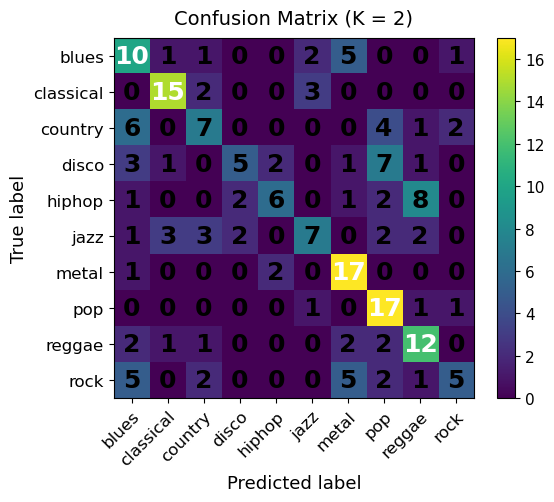


=== Training GMMs with K=8 ===


Training GMMs (K=8): 100%|██████████| 10/10 [00:40<00:00,  4.06s/it]
Evaluating K=8, true=blues: 20it [00:00, 44.80it/s]
Evaluating K=8, true=classical: 20it [00:00, 46.07it/s]
Evaluating K=8, true=country: 20it [00:00, 47.18it/s]
Evaluating K=8, true=disco: 20it [00:00, 46.67it/s]
Evaluating K=8, true=hiphop: 20it [00:00, 44.88it/s]
Evaluating K=8, true=jazz: 20it [00:00, 44.92it/s]
Evaluating K=8, true=metal: 20it [00:00, 43.84it/s]
Evaluating K=8, true=pop: 20it [00:00, 43.00it/s]
Evaluating K=8, true=reggae: 20it [00:00, 44.04it/s]
Evaluating K=8, true=rock: 20it [00:00, 44.43it/s]


Accuracy (K = 8): 0.6100


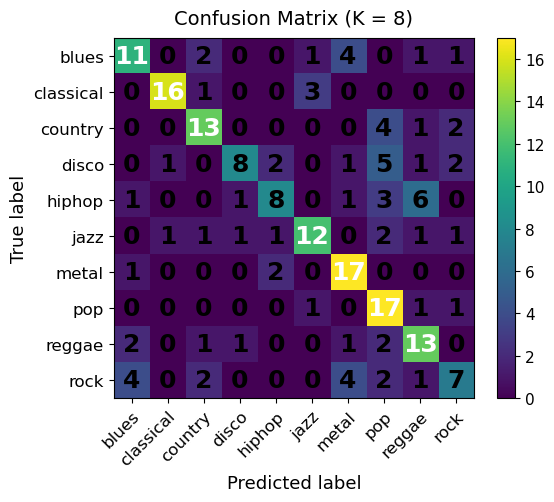


=== Training GMMs with K=16 ===


Training GMMs (K=16): 100%|█████████| 10/10 [01:14<00:00,  7.49s/it]
Evaluating K=16, true=blues: 20it [00:00, 37.68it/s]
Evaluating K=16, true=classical: 20it [00:00, 39.99it/s]
Evaluating K=16, true=country: 20it [00:00, 36.79it/s]
Evaluating K=16, true=disco: 20it [00:00, 40.36it/s]
Evaluating K=16, true=hiphop: 20it [00:00, 38.09it/s]
Evaluating K=16, true=jazz: 20it [00:00, 39.12it/s]
Evaluating K=16, true=metal: 20it [00:00, 39.05it/s]
Evaluating K=16, true=pop: 20it [00:00, 39.39it/s]
Evaluating K=16, true=reggae: 20it [00:00, 38.81it/s]
Evaluating K=16, true=rock: 20it [00:00, 38.59it/s]


Accuracy (K = 16): 0.6550


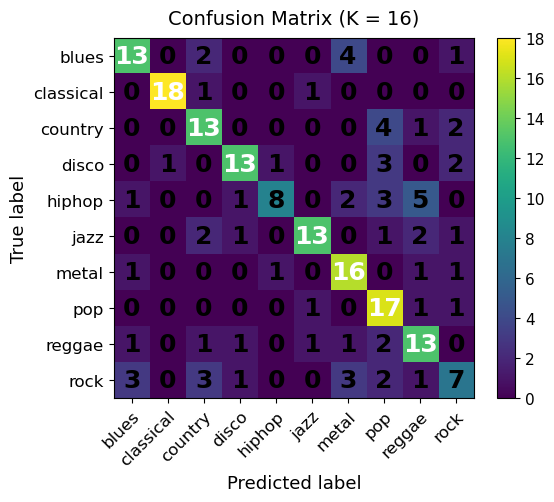


=== Training GMMs with K=64 ===


Training GMMs (K=64): 100%|█████████| 10/10 [04:06<00:00, 24.69s/it]
Evaluating K=64, true=blues: 20it [00:01, 14.82it/s]
Evaluating K=64, true=classical: 20it [00:01, 15.16it/s]
Evaluating K=64, true=country: 20it [00:01, 16.61it/s]
Evaluating K=64, true=disco: 20it [00:01, 16.28it/s]
Evaluating K=64, true=hiphop: 20it [00:01, 16.23it/s]
Evaluating K=64, true=jazz: 20it [00:01, 15.97it/s]
Evaluating K=64, true=metal: 20it [00:01, 15.93it/s]
Evaluating K=64, true=pop: 20it [00:01, 15.18it/s]
Evaluating K=64, true=reggae: 20it [00:01, 15.20it/s]
Evaluating K=64, true=rock: 20it [00:01, 15.02it/s]


Accuracy (K = 64): 0.7000


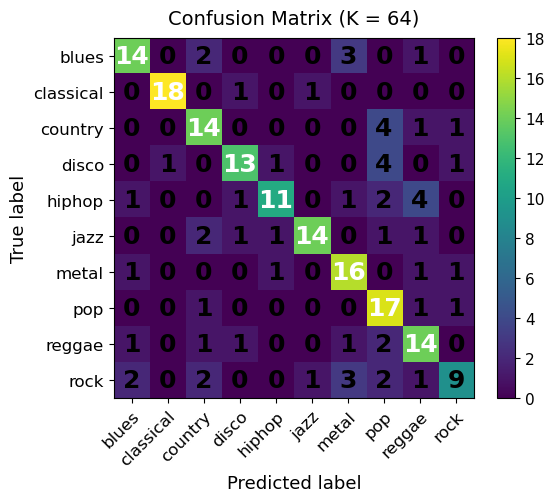

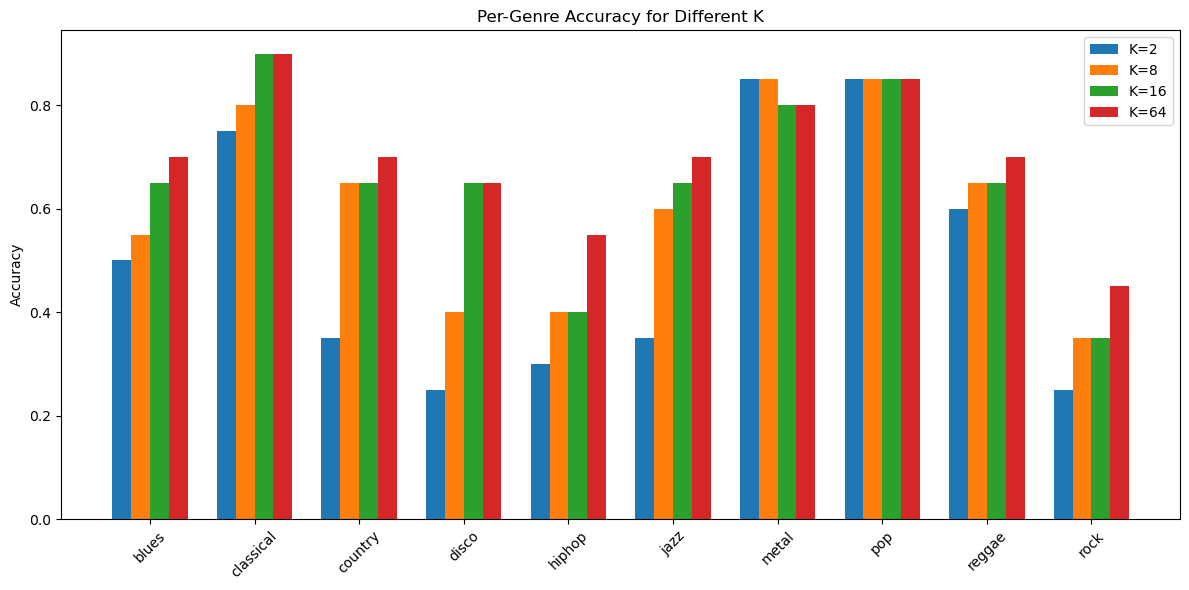

In [92]:
if BUILD_FEATURES:
    build_features()

results = {}              # overall accuracy per K
genre_results = {}        # per-genre accuracy per K

for K in Ks:
    if TRAIN:
        print(f"\n=== Training GMMs with K={K} ===")
        train_gmm_system(K)

    acc, cm = evaluate_system(K)

    results[K] = acc

    # per-genre accuracy
    per_genre_acc = {}
    for i, genre in enumerate(GENRES):
        per_genre_acc[genre] = cm[i, i] / cm[i].sum()

    genre_results[K] = per_genre_acc

    print(f"Accuracy (K = {K}): {acc:.4f}")
    plot_confusion_matrix(cm, GENRES, title=f"Confusion Matrix (K = {K})")

acc_table = pd.DataFrame.from_dict(
    results, orient="index", columns=["Accuracy"]
)

acc_table.index.name = "K"
acc_table

genre_acc_table = pd.DataFrame.from_dict(
    genre_results, orient="index"
)

x = np.arange(len(GENRES))
width = 0.18

plt.figure(figsize=(12, 6))

for i, K in enumerate(Ks):
    plt.bar(
        x + i * width,
        genre_acc_table.loc[K, GENRES],
        width,
        label=f"K={K}"
    )

plt.xticks(x + width * (len(Ks) - 1) / 2, GENRES, rotation=45)
plt.ylabel("Accuracy")
plt.title("Per-Genre Accuracy for Different K")
plt.legend()
plt.tight_layout()
plt.show()